# Modules importation and data loading

In [609]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
%matplotlib inline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import TruncatedSVD# SVD = Singular Value Descomposition
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler, MaxAbsScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.feature_extraction import stop_words
from sklearn.base import TransformerMixin
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabaz_score
from sklearn.preprocessing import Normalizer, LabelBinarizer, OneHotEncoder

random_state=0

In [610]:
# Data loading
NROWS = sys.maxsize
## Negative dataset
df_neg = pd.read_csv('./practica_clase/PRECISION_MEDICINE/negative_training_abstracts.tsv', sep='\t', 
                     header=None, nrows = NROWS)

df_neg.columns = ['Accession number', 'Title', 'Abstract']
df_neg['Label'] = '0' #'neg'

display(df_neg.head())

corpus_neg = list(df_neg['Abstract'].values)
### len(corpus_neg) # 4078

## Positive
df_pos = pd.read_csv('./practica_clase/PRECISION_MEDICINE/positive_training_abstracts.tsv', sep='\t', 
                     header=None, nrows = NROWS)

df_pos.columns = ['Accession number', 'Title', 'Abstract']
df_pos['Label'] = '1' # 'pos'
display(df_pos.head())

# Add corpus
df_corpus = df_neg.append(df_pos)
display(df_corpus.head())

# len(corpus) # 8156

labels = df_corpus['Label']
corpus = df_corpus['Abstract']
# len(labels) # 8156

print(len(corpus), len(labels))

,Accession number,Title,Abstract,Label
0,29606186,Can reactivity and regulation in infancy predi...,A need to identify early infant markers of lat...,0
1,29471205,"Fabrication of bioinspired, self-cleaning supe...","The mechanical properties, corrosion-resistanc...",0
2,29175165,Functional properties of chickpea protein isol...,"In the present study, the effect of Refractanc...",0
3,29098524,Mechanical dyssynchrony alters left ventricula...,The impact of left bundle branch block (LBBB) ...,0
4,27507285,Reducing the width of confidence intervals for...,"In the last decade, it has been shown that an ...",0


,Accession number,Title,Abstract,Label
0,27829177,A naturally occurring variant of HPV-16 E7 exe...,Human Papillomavirus E6 and E7 play critical r...,1
1,27806271,Functional Analysis of Orai1 Concatemers Suppo...,Store-operated Ca(2+) entry occurs through the...,1
2,27796307,KAT2A/KAT2B-targeted acetylome reveals a role ...,Lysine acetylation is a widespread post-transl...,1
3,27795438,The Cellular DNA Helicase ChlR1 Regulates Chro...,"In papillomavirus infections, the viral genome...",1
4,27794539,Human R1441C LRRK2 regulates the synaptic vesi...,Mutations in leucine-rich repeat kinase 2 (LRR...,1


,Accession number,Title,Abstract,Label
0,29606186,Can reactivity and regulation in infancy predi...,A need to identify early infant markers of lat...,0
1,29471205,"Fabrication of bioinspired, self-cleaning supe...","The mechanical properties, corrosion-resistanc...",0
2,29175165,Functional properties of chickpea protein isol...,"In the present study, the effect of Refractanc...",0
3,29098524,Mechanical dyssynchrony alters left ventricula...,The impact of left bundle branch block (LBBB) ...,0
4,27507285,Reducing the width of confidence intervals for...,"In the last decade, it has been shown that an ...",0


8156 8156


## Data split

In [611]:
TEST_SIZE = 0.33
X_train, X_test, y_train, y_test = train_test_split(
    corpus, labels, test_size=0.33, random_state=random_state)

# Part I. Construction of an automatic classifier

The following parameters can be adjusted in order to try to maximize the quality of the
classifier:

- In function TfidfVectorizer:
    * Parameters that affect the vocabulary quality:
        * List of stopwords (one of the options is setting it to None)
        * maxfeatures
        * max_df, min_df
    * Norm (none, ‘l1’ or ‘l2’)
    
- In Latent Semantic Analysis (LSA):
    * n_components
    * not performing LSA
    
- Classifier model:
    * You can use strategies included in some of the notebooks we used 
        * Logistic Regression, 
        * Naïve Bayes, 
        * decision trees, 
        * SVC
        * or others you learnt from the Machine Learning course (k-nn, neural networks, etc.)

The goal is not to check all possible combinations of these parameters but respond to thesequestions:

- Which tips can you give about constructing an automatic text classifier? What do you recommend to do? What do you recommend not to do?
- What is the best classifier you have obtained?

Your responses to these questions should be illustrated with tables and/or figures and/or
screen captures.

## Pipelines

### Find additional stopwords

In [470]:
def get_top_n_words(corpus, n=None):
    """
    List the top n words in a vocabulary according to occurrence in a text corpus.
    """
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    
    return words_freq[:n]

def improve_stop_words(X_train, n=50):
    """
    """
    common_words = [i[0] for i in get_top_n_words(X_train, n)]
    eng_and_custom_stopwords = set(list(stop_words.ENGLISH_STOP_WORDS) + common_words)
    print(len(eng_and_custom_stopwords))
    return eng_and_custom_stopwords

### Pipelining methods

In [527]:
CLASSIFIERS = ['knn', 'dtree', 'nb', 'lr', 'svc', 'lsvc']
CLASSIFIERS_FROM_CLUSTERS = ['kmeans']
REDUCERS = ['svd', None]
CV = 4

class KMeans_foo(KMeans):
    def fit_transform(self, X, y=None):
        return self.fit_predict(X)

class Transformer(TransformerMixin):
    def __init__(self, model):
        self.model = model

    def fit(self, y=None, *args, **kwargs):
        self.model.fit(*args, **kwargs)
        return self

    def transform(self, X, **transform_params):
        return pd.DataFrame(self.model.predict(X))
    
def create_text_pipeline(reducer='svd', classifier="nb"):
    """ Create text vectorization pipeline with optional dimensionality reduction"""
    assert reducer in REDUCERS, "ERROR: Reducer %s not supported, only %s" % (reducer, REDUCERS)
    assert classifier in CLASSIFIERS + CLASSIFIERS_FROM_CLUSTERS,\
        "ERROR: Classifier %s not supported, only %s" % (classifier, CLASSIFIERS + CLASSIFIERS_FROM_CLUSTERS)
    pipeline = [
        ('vect', TfidfVectorizer()),
        ('scaler', StandardScaler())
    ]
    num_comp = 3
    # Reduce dimensions
    if reducer == 'svd':
        pipeline.append(('red_svd', TruncatedSVD()))
        pipeline.append(('norm', MinMaxScaler()))
    elif reducer == 'kbest':
        pipeline.append(('red_kbest', SelectKBest(k=num_comp)))
        pipeline.append(('norm', MinMaxScaler()))
    elif reducer == 'percentile':
        pipeline.append(('red_percentile', SelectPercentile(f_classif, percentile=num_comp)))
        pipeline.append(('norm', MinMaxScaler()))
    elif reducer == None:
        #pipeline.append(('normalizer', MaxAbsScaler()))
        pass
    
    # Classify
    if classifier == "nb":
        pipeline.append(('clf_' + classifier, MultinomialNB()))
    elif classifier == "lr":
        pipeline.append(('clf_' + classifier, LogisticRegression()))
    elif classifier == "svc":
        pipeline.append(('clf_' + classifier, SVC()))
    elif classifier == "lsvc":
        pipeline.append(('clf_' + classifier, LinearSVC()))
    elif classifier == "dtree":
        pipeline.append(('clf_' + classifier, DecisionTreeClassifier())) 
    elif classifier == "knn":
        pipeline.append(('clf_' + classifier, KNeighborsClassifier()))    
    elif classifier == "kmeans":
        pipeline.append(('normalizer', Normalizer()))
        #pipeline.append(('cluster_kmeans' + classifier, Transformer(KMeans_foo(2))))
        pipeline.append(('cluster_kmeans', KMeans(2)))
        pipeline.append(('one_hot_encoder', OneHotEncoder(sparse=False)))
        #pipeline.append(('binarize', LabelBinarizer()))
    elif classifier == None:
        pass
    
    print("Pipeline", pipeline)
    return Pipeline(pipeline)

def prediction_metrics(X_train, y_train, X_test, y_test, parameters, reducer="svd", classifier="nb"):
    """
    """
    print("### Reducer: %s   Classifier: %s" %(reducer, classifier))
    pipeline = create_text_pipeline(reducer=reducer, classifier=classifier)
    # Filter params to only the params related with the pipeline steps
    filtered_params = {}
    for param_key in parameters.keys():
        if param_key.split('__')[0] in pipeline.named_steps.keys():
            filtered_params[param_key] = parameters[param_key]
    pipeline.set_params(**filtered_params)
    pipeline.fit(X_train, y_train)
    if classifier == "kmeans":
        predicted = pipeline.fit_transform(X_test)
        print(predicted)
        print(y_test)
    else:
        predicted = pipeline.predict(X_test)
    print(metrics.classification_report(y_test, predicted))
    print(metrics.confusion_matrix(y_test, predicted))
    
def process_classifications(X_train, y_train, X_test, y_test, parameters, 
                            classifiers=CLASSIFIERS, reducers=REDUCERS):
    """
    """
    for classifier in classifiers:
            for reducer in reducers:
                prediction_metrics(X_train, y_train, X_test, y_test, parameters, reducer, classifier)
                
def prediction_metrics_grid(X_train, y_train, X_test, y_test, parameters_grid, reducer="svd", classifier="nb", cv=CV):
    """
    """
    print("### Reducer: %s   Classifier: %s" %(reducer, classifier))
    pipeline = create_text_pipeline(reducer=reducer, classifier=classifier)
    # Filter params to only the params related with the pipeline steps
    filtered_params = {}
    for param_key in parameters_grid.keys():
        if param_key.split('__')[0] in pipeline.named_steps.keys():
            filtered_params[param_key] = parameters_grid[param_key]     
    grid_model = GridSearchCV(pipeline, filtered_params, cv=cv, iid=False)
    grid_model.fit(X_train, y_train)
    for param_name in sorted(filtered_params.keys()):
        print("\t%s: %r" % (param_name, grid_model.best_params_[param_name]))  
    pipeline.set_params(**grid_model.best_params_)
    pipeline.fit(X_train, y_train)
    predicted = pipeline.predict(X_test)
    print(metrics.classification_report(y_test, predicted))
    print(metrics.confusion_matrix(y_test, predicted))
    
def process_classifications_grid(X_train, y_train, X_test, y_test, parameters, cv=CV,
                            classifiers=CLASSIFIERS, reducers=REDUCERS):
    """
    """
    for classifier in classifiers:
            for reducer in reducers:
                prediction_metrics_grid(X_train, y_train, X_test, y_test, parameters, reducer, classifier, cv=cv)

## Main process with prefixed parameters

In [498]:
# First set of parameters
param_set_1 = { 
    'vect__norm': None,
    'vect__smooth_idf': True,
    'vect__sublinear_tf': True,
    'vect__max_features': 1000,
    'vect__min_df': 6,
    'vect__stop_words': 'english',
    'vect__strip_accents' : 'unicode',
    'vect__analyzer' : 'word',
    'vect__token_pattern': r'\w{1,}', 
    'vect__ngram_range' : (1, 2),
    'scaler__with_mean' : False,
    'vect__norm': 'l2',
    'red_svd__n_components': 40,
    'clf_knn__n_neighbors' : 2
}

# More stop words
#eng_and_custom_stopwords = improve_stop_words(X_train, 200)
#param_set_1['vect__stop_words'] = eng_and_custom_stopwords

#process_classifications(X_train, y_train, X_test, y_test, param_set_1, reducers=['svd'], classifiers=['nb'])

process_classifications(X_train, y_train, X_test, y_test, param_set_1)

### Reducer: svd   Classifier: knn
              precision    recall  f1-score   support

           0       0.68      1.00      0.81        15
           1       1.00      0.61      0.76        18

   micro avg       0.79      0.79      0.79        33
   macro avg       0.84      0.81      0.78        33
weighted avg       0.86      0.79      0.78        33

[[15  0]
 [ 7 11]]
### Reducer: None   Classifier: knn
              precision    recall  f1-score   support

           0       0.60      1.00      0.75        15
           1       1.00      0.44      0.62        18

   micro avg       0.70      0.70      0.70        33
   macro avg       0.80      0.72      0.68        33
weighted avg       0.82      0.70      0.68        33

[[15  0]
 [10  8]]
### Reducer: svd   Classifier: dtree
              precision    recall  f1-score   support

           0       0.83      1.00      0.91        15
           1       1.00      0.83      0.91        18

   micro avg       0.91      0.91   

## Main process with grid search parameters

In [462]:
parameters_grid = {
    'vect__min_df': [5, 6],
    #'vect__max_df': [10, 11],
    'vect__stop_words': (None, 'english', eng_and_custom_stopwords),
    'vect__max_features': [50],
    #'vect__smooth_idf': [True, False],
    'vect__norm': ['l1', 'l2', None]
    #'red_svd__n_components': (50, 100, 200, None),
    #'red_svd__n_components': (10, 20, 30, None),
    #'clf_nb__alpha': (1e-1, 1e-2, 1e-3)
}

parameters_grid = {
    'vect__norm': ['l1', 'l2', None],
    'vect__smooth_idf': [True],
    'vect__sublinear_tf': [True],
    'vect__max_features': [900, 1000],
    'vect__min_df': [5, 6],
    #'vect__max_df': [7,8],
    'vect__stop_words': [None, 'english', eng_and_custom_stopwords],
    'vect__strip_accents' : ['unicode'],
    'vect__analyzer' : ['word'],
    'vect__token_pattern': [r'\w{1,}'], 
    'vect__ngram_range' : [(1, 2)],
    'scaler__with_mean' : [False],
    'red_svd__n_components': [2, 30, 40],
    'clf_knn__n_neighbors' : [2, 5]
}

eng_and_custom_stopwords = improve_stop_words(X_train, 200)
#prediction_metrics_grid(X_train, y_train, X_test, y_test, parameters_grid, reducer='svd', classifier="knn", cv=2)
process_classifications_grid(X_train, y_train, X_test, y_test, parameters_grid, cv=2)

448
### Reducer: svd   Classifier: knn
	clf_knn__n_neighbors: 5
	red_svd__n_components: 2
	scaler__with_mean: False
	vect__analyzer: 'word'
	vect__max_features: 900
	vect__min_df: 5
	vect__ngram_range: (1, 2)
	vect__norm: 'l2'
	vect__smooth_idf: True
	vect__stop_words: None
	vect__strip_accents: 'unicode'
	vect__sublinear_tf: True
	vect__token_pattern: '\\w{1,}'
              precision    recall  f1-score   support

           0       0.96      0.91      0.93       163
           1       0.92      0.96      0.94       167

   micro avg       0.94      0.94      0.94       330
   macro avg       0.94      0.94      0.94       330
weighted avg       0.94      0.94      0.94       330

[[149  14]
 [  7 160]]
### Reducer: None   Classifier: knn
	clf_knn__n_neighbors: 5
	scaler__with_mean: False
	vect__analyzer: 'word'
	vect__max_features: 1000
	vect__min_df: 6
	vect__ngram_range: (1, 2)
	vect__norm: 'l2'
	vect__smooth_idf: True
	vect__stop_words: None
	vect__strip_accents: 'unicode'
	vect_

# Part 2: Construction of a clustering of biology documents
We already know the class information in our dataset (positive and negative) but we will test if an automatic clustering system discovers automatically these classes (“labels”). The objective is to learn strategies that will be very useful when we have to cluster unlabeled documents. Therefore, we “hide” this information (the real class) to the clustering algorithm. 

The objective in this section is to check what are the parameters that maximize clustering’s quality. The parameters to be taken into account are:

- In function TfidfVectorizer:

    * Vocabulary (larger or smaller)
    * Norm (none, ‘l1’ or ‘l2’)
    
- In Latent Semantic Analysis (LSA):

    * n_components
    * o not performing LSA
    
- Normalize the data/not normalize it with “Normalizer” (included in the notebook).

The questions to be responded in this part are:

- Which tips can you give about constructing a text clustering with k-means? What do you recommend to do? What do you recommend not to do?

- What is the best clustering you have obtained? The quality of the cluster is the degree of correspondence between real class and assigned cluster. For example:

    * If there are 2 clusters and cluster 0 contains all examples of positive class and cluster 1 contains all examples of negative class, the clustering is perfect.
    * If there are 2 clusters and cluster 1 contains all examples of positive class and cluster 0 contains all examples of negative class, the clustering is also perfect.
    *  If there are 2 clusters and cluster 0 contains 50% of examples of positive class and 50% of examples of negative class, and statistics in cluster 1 are similar, the clustering quality is the worst possible.

In [612]:
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabaz_score
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

vectorizador = TfidfVectorizer(max_df=1., max_features=1000, norm='l2',
                               min_df=1, stop_words='english',
                               #stop_words=stopwords,
                               #token_pattern=r'(?u)\b[A-Za-z]+\b',
                               #token_pattern=r'(?ui)\b\w*[a-z]+\w*\b',
                               use_idf=True)
X = vectorizador.fit_transform(X_test)

print(X.shape)
n_componentes = 100
svd_truncado = TruncatedSVD(n_componentes)
normalizador = Normalizer(copy=False)

lsa = make_pipeline(svd_truncado, normalizador)
#lsa = svd_truncado

X_lsa = lsa.fit_transform(X)

varianza_explicada = svd_truncado.explained_variance_ratio_.sum()
normalizer = Normalizer()
X_lsa_norm = normalizer.fit_transform(X_lsa)
X_km = X_lsa_norm

qmetric = calinski_harabaz_score

Nclusters_max = 15
Nrepetitions = 100

qualities = []
inertias = []
models = []
kini = 1
kfin = 4
for k in range(kini,kfin+1):
    print("Evaluando k=%d" % k)
    km = KMeans(n_clusters=k,
                init='k-means++', n_init=Nrepetitions,
                max_iter=500, random_state=2)    
    km.fit(X_km)
    models.append(km)
    inertias.append(km.inertia_)
    if k >1:
        qualities.append(qmetric(X_km, km.labels_))
    else:
        qualities.append(0)

(2692, 1000)
Evaluando k=1
Evaluando k=2
Evaluando k=3
Evaluando k=4


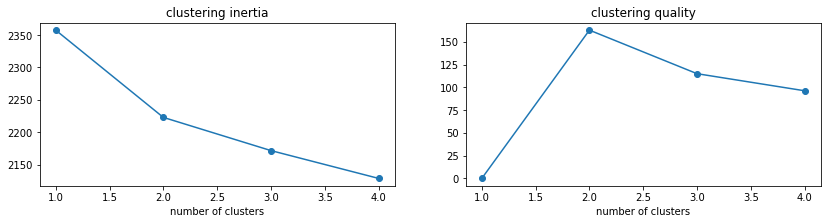

Best number of clusters 1
Number of clusters of best quality 2


In [613]:
fig = plt.figure(figsize=(14,3))

ax = plt.subplot(1,2,1)
plt.plot(range(kini,kfin+1), inertias, marker='o')
plt.xlabel('number of clusters')
plt.title('clustering inertia')

ax = plt.subplot(1,2,2)
plt.plot(range(kini,kfin+1), qualities, marker='o')
plt.xlabel('number of clusters')
plt.title('clustering quality')
plt.show()

best = pd.Series(qualities).idxmax() # get index for the best model
print("Best number of clusters", best)
km = models[best]
n_clusters = km.get_params()['n_clusters']
clusters = km.labels_
print ('Number of clusters of best quality', n_clusters)

In [616]:
# We choose the best option to evaluate the quality of prediction

# First we try with labels as is 
labels_predicted = [str(label) for label in km.labels_]
predicted = pd.Series(labels_predicted)
print(metrics.classification_report(y_test, predicted))
print(metrics.confusion_matrix(y_test, predicted))

# Alternatively we invert the label to match the real labels of each group
labels_predicted = [str((label + 1)%2) for label in km.labels_]
predicted = pd.Series(labels_predicted)
print(metrics.classification_report(y_test, predicted))
print(metrics.confusion_matrix(y_test, predicted))

              precision    recall  f1-score   support

           0       0.99      0.87      0.93      1348
           1       0.88      0.99      0.93      1344

   micro avg       0.93      0.93      0.93      2692
   macro avg       0.94      0.93      0.93      2692
weighted avg       0.94      0.93      0.93      2692

[[1169  179]
 [   7 1337]]
              precision    recall  f1-score   support

           0       0.12      0.13      0.12      1348
           1       0.01      0.01      0.01      1344

   micro avg       0.07      0.07      0.07      2692
   macro avg       0.06      0.07      0.07      2692
weighted avg       0.06      0.07      0.07      2692

[[ 179 1169]
 [1337    7]]


## Pipelining

Can I put all in the pipeline defined previously?

In [ ]:
# First set of parameters
param_set_1 = { 
    'vect__norm': None,
    'vect__smooth_idf': True,
    'vect__sublinear_tf': True,
    'vect__max_features': 1000,
    'vect__min_df': 6,
    'vect__stop_words': 'english',
    'vect__strip_accents' : 'unicode',
    'vect__analyzer' : 'word',
    'vect__token_pattern': r'\w{1,}', 
    'vect__ngram_range' : (1, 2),
    'scaler__with_mean' : False,
    'vect__norm': 'l2',
    'red_svd__n_components': 40,
    'clf_knn__n_neighbors' : 2
}

# More stop words
#eng_and_custom_stopwords = improve_stop_words(X_train, 200)
#param_set_1['vect__stop_words'] = eng_and_custom_stopwords

process_classifications(X_train, y_train, X_test, y_test, param_set_1, reducers=['svd'], classifiers=['kmeans'])

#process_classifications(X_train, y_train, X_test, y_test, param_set_1)

# Outputs

In [618]:
%%bash
jupyter nbconvert --to=latex --template=~/report.tplx TextMining_Assignment.ipynb 1>/dev/null 2>/dev/null
/Library/TeX/texbin/pdflatex -shell-escape TextMining_Assignment 1>/dev/null 2>/dev/null
jupyter nbconvert --to html_toc TextMining_Assignment.ipynb 1>/dev/null 2>/dev/null